In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from medmnist import PneumoniaMNIST

In [2]:
# Set random seeds for reproducibility
random.seed(42) # Set Python random seed
tf.random.set_seed(42)
np.random.seed(42)

train_dataset = PneumoniaMNIST(split="train", download=True)
validation_dataset = PneumoniaMNIST(split="val", download=True)
test_dataset = PneumoniaMNIST(split="test", download=True)

In [3]:
images = []
labels = []
for img_tensor, label in train_dataset:
    images.append(np.array(img_tensor))
    labels.append(label.item()) 
x_train = np.stack(images)  
y_train = np.array(labels)  
x_train = np.expand_dims(x_train, axis=-1)
print(f"x_train shape: {x_train.shape}") 
print(f"y_train shape: {y_train.shape}")

x_train shape: (4708, 28, 28, 1)
y_train shape: (4708,)


In [4]:
images = []
labels = []
for img_tensor, label in validation_dataset:
    images.append(np.array(img_tensor))
    labels.append(label.item()) 
x_validation = np.stack(images)  
y_validation = np.array(labels)  
x_validation = np.expand_dims(x_validation, axis=-1)
print(f"x_validation shape: {x_validation.shape}") 
print(f"y_validation shape: {y_validation.shape}")

x_validation shape: (524, 28, 28, 1)
y_validation shape: (524,)


In [5]:
images = []
labels = []
for img_tensor, label in test_dataset:
    images.append(np.array(img_tensor))
    labels.append(label.item()) 
x_test = np.stack(images)  
y_test = np.array(labels)  
x_test = np.expand_dims(x_test, axis=-1)
print(f"x_test shape: {x_test.shape}") 
print(f"y_test shape: {y_test.shape}")

x_test shape: (624, 28, 28, 1)
y_test shape: (624,)


In [6]:
if x_train.max() > 1:
    x_train = x_train.astype(np.float32) / 255.0
if x_validation.max() > 1:
    x_validation = x_validation.astype(np.float32) / 255.0
if x_test.max() > 1:
    x_test = x_test.astype(np.float32) / 255.0

In [7]:
def test_model_and_evaluate(model):
    y_pred_prob = model.predict(x_test)
    print(f"Predicted probabilities shape: {y_pred_prob.shape}")
    y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes))
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    per_class_accuracy = np.diagonal(cm) / np.sum(cm, axis=1)
    print("Per-class Accuracy:")
    for i, accuracy in enumerate(per_class_accuracy):
        class_name = 'Normal' if i == 0 else 'Pneumonia'
        print(f"Class {class_name}: {accuracy:.4f}")

def print_accuracy_and_loss(history): 
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Class weights: {0: np.float64(1.9390444810543657), 1: np.float64(0.6737263880938752)}


In [9]:
def binary_focal_loss(gamma=2.0, alpha=0.15):
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        loss = -alpha_t * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss

In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1),
           kernel_regularizer=regularizers.l2(0.005)),  
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4), 
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.005)),  
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)), 
    Dropout(0.6), 
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss=binary_focal_loss(gamma=2.0, alpha=0.15),
    metrics=['accuracy']
)
model.summary()

c:\Users\bigma\.virtualenvs\Pneumonia-Detection-1PsfeFAi\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,033 (859.50 KB)

 Trainable params: 219,841 (858.75 KB)

 Non-trainable params: 192 (768.00 B)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1, min_lr=1e-6)
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    # steps_per_epoch=len(x_train) // 64,
    epochs=40,
    validation_data=(x_validation, y_validation),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\bigma\.virtualenvs\Pneumonia-Detection-1PsfeFAi\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5405 - loss: 0.9847 - val_accuracy: 0.7424 - val_loss: 0.7220 - learning_rate: 5.0000e-04
Epoch 2/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6891 - loss: 0.6183 - val_accuracy: 0.7424 - val_loss: 0.6909 - learning_rate: 5.0000e-04
Epoch 3/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7482 - loss: 0.4624 - val_accuracy: 0.7424 - val_loss: 0.7062 - learning_rate: 5.0000e-04
Epoch 4/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7618 - loss: 0.3560 - val_accuracy: 0.7424 - val_loss: 0.6385 - learning_rate: 5.0000e-04
Epoch 5/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7893 - loss: 0.2787 - val_accuracy: 0.7634 - val_loss: 0.4003 - learning_rate: 5.0000e-04
Epoch 6/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8169 - loss: 0.2185 - val_accuracy: 0.8645 - val_loss: 0.2372 - learning_rate: 5.0000e-04
Epoch 7/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8248 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicted probabilities shape: (624, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8905 - loss: 0.0523
Test Loss: 0.0543
Test Accuracy: 0.8926
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       234
           1       0.90      0.93      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



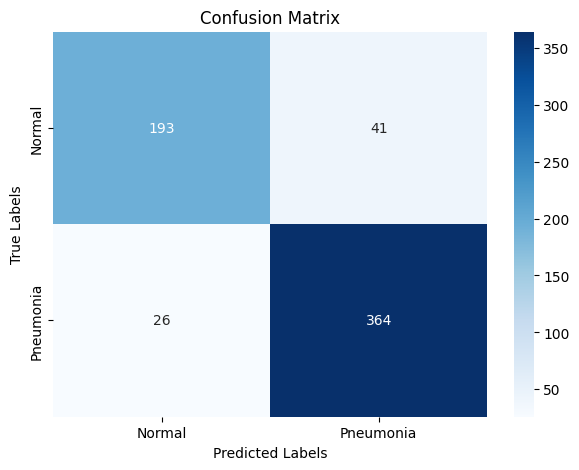

Per-class Accuracy:
Class Normal: 0.8248
Class Pneumonia: 0.9333


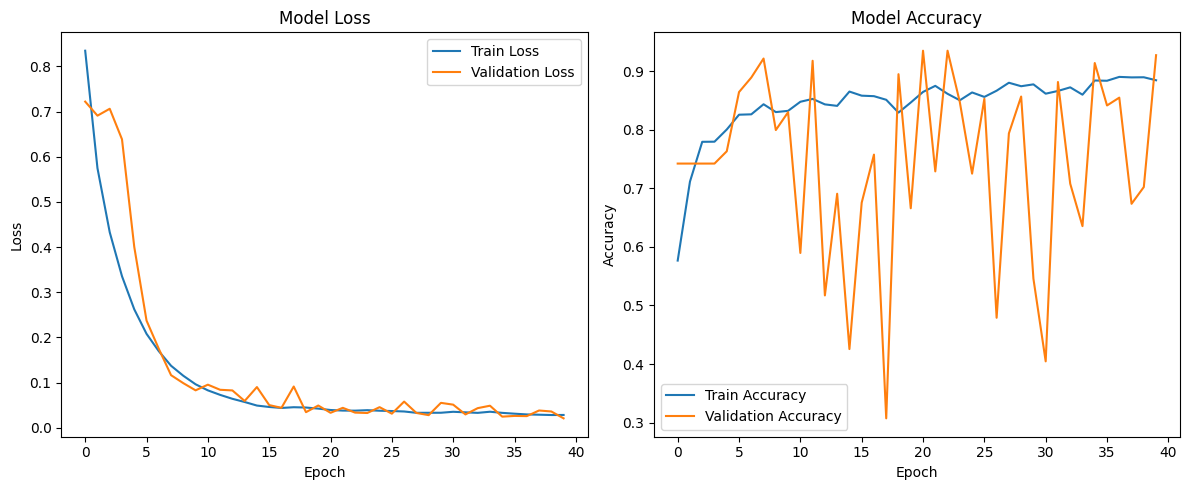

In [ ]:
test_model_and_evaluate(model) # with python random.seed(42), after Jupyter kernel restart: Test Accuracy: 0.8926
print_accuracy_and_loss(history)